# Importar librerías a utilizar

In [1]:
!pip install contexto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 KB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 KB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA

import sklearn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

import requests 
import time
from tqdm import tqdm
from multiprocessing.dummy import Pool
import pandas as pd
import random
from datetime import datetime
import pytz
import re
import string
import numpy as np


from contexto.limpieza import *
from nltk.stem import PorterStemmer
import nltk
import time
from contexto.stemming import Stemmer, stem_texto

import time
from contexto.lematizacion import LematizadorSpacy, LematizadorStanza
from contexto.lematizacion import lematizar_texto

from contexto.exploracion import obtener_ngramas
from contexto.exploracion import nube_palabras
from contexto.exploracion import par_nubes

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import os
import pandas as pd


# Cargar bases de datos de entrenamiento

In [12]:
train = pd.read_csv(r"/content/train.csv")

# Limpiar base de datos

In [13]:
# Asignar a cada autor de tweets un número, para cambiar de texto a categoría
train['name'].iloc[train['name']=='Petro']= 1
train['name'].iloc[train['name']=='Uribe'] = 2
train['name'].iloc[train['name']=='Lopez'] = 3
train['name'] = train['name'].astype(int)

In [14]:
# Ver la base de entrenamiento
train

,id,name,text
0,5f993ca6ab24ecb07efc5259,1,Me gustaría que esta columna fuera deliberada ...
1,f8734ee208059bc34690fbe8,3,¡Si Bogotá y Cundinamarca salen adelante Colom...
2,cfd3678247b29ea7ba1fbe3c,3,Esto significa el proyecto de acuerdo de resca...
3,e13d9e299ac5ffd38f503c5a,3,¡Avanza nuestro recorrido por San Cristóbal! \...
4,fc457807261de42e57f5c1c5,1,Miles de personas en Bucaramanga en estos mome...
...,...,...,...
9344,a9bbd1f1a75509dfbfd58989,2,El CD apoya: \n\nConstrucción de política para...
9345,5444d8088d86cbb383ea478c,1,La educación superior sin duda es clave para l...
9346,ea1e50eeb549aa47ea59a9db,2,"""En Pasto el 21.8% de jóvenes entre 15 y 28 añ..."
9347,7746b5b0907344492c91201e,3,"Lo material lo vamos a recuperar, las vidas qu..."


In [15]:
# Convertir en lista cada una de las columnas de la base de entrenamiento
text ={'id': train['id'].to_list(),'name': train['name'].to_list(), 'text': train['text'].to_list()}

In [16]:
# Definir la lista de stopwords
stopwords = []
lis = [lista_nombres()[0], lista_apellidos()[0],lista_geo_colombia()[0], lista_geo_colombia()[1], 
       lista_stopwords()]
for i in lis:
    stopwords.extend(i)

In [17]:
# Crear función para limpiar el texto
def limpiar(text):
    text = remover_stopwords(text, lista_palabras= stopwords)
    text = re.sub(r"http\S+", "", text) # Eliminar hipervínculos
    text = quitar_repetidos(text, ",") # Eliminar palabras que, estando una coma, están repetidas
    text = limpieza_basica(text) # Eliminar signos de puntuación, números y transformar todo a minúscula
    text = remover_acentos(text) # Eliminar acentos
    text = remover_palabras_cortas(text, 4) # Eliminar palabras que tengan 4 caracteres o menos
    return text

In [18]:
# Aplicar la función de limpieza creada y aplicar stemmer y lematizador a la base de entrenamiento
re_limp=[]
for i in tqdm(text['text']):
    re_limp.append(limpiar(i))

# Stemmer
stemmer = Stemmer(lenguaje='español')

corpus_stem=[]
for i in tqdm(re_limp):
    stem = stem_texto(i, stemmer=stemmer)
    corpus_stem.append(stem)

train_stem = train.drop(['text'], axis=1)
train_stem['text'] = corpus_stem

# Lematizador
lematizador = LematizadorSpacy('es')

corpus_lem =[]
for i in tqdm(re_limp):
    lem = lematizar_texto(i, lematizador=lematizador)
    corpus_lem.append(lem)

train_lem = train.drop(['text'], axis=1)
train_lem['text'] = corpus_lem

train_lem

100%|██████████| 9349/9349 [00:51<00:00, 179.82it/s]


,id,name,text
0,5f993ca6ab24ecb07efc5259,1,gustario columna deliberado punto resistencia ...
1,f8734ee208059bc34690fbe8,3,salir adelante adelante trabajar junto reconoc...
2,cfd3678247b29ea7ba1fbe3c,3,este significar proyecto acuerdo rescate socia...
3,e13d9e299ac5ffd38f503c5a,3,avanzar recorrido cristobal llegar colegio ter...
4,fc457807261de42e57f5c1c5,1,mil persona momento calle paronacional termina...
...,...,...,...
9344,a9bbd1f1a75509dfbfd58989,2,apoyar construccion politico jovenes austerida...
9345,5444d8088d86cbb383ea478c,1,educacion superior duda clave disminucion desi...
9346,ea1e50eeb549aa47ea59a9db,2,jovenes anos desempleado trofimoff foro centro...
9347,7746b5b0907344492c91201e,3,material ir recuperar vida perder cambio doler...


# Crear WordCloud

In [19]:
from wordcloud import WordCloud

## General

Words: 1200653


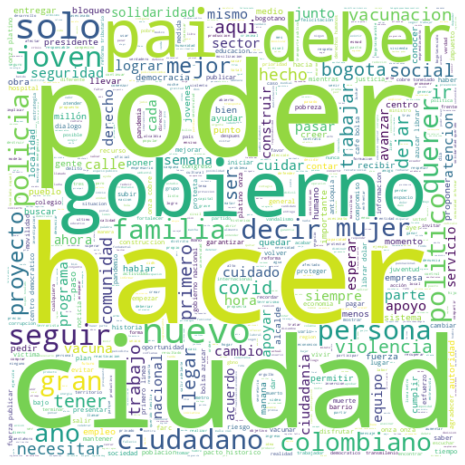

In [20]:
df2 = train_lem.dropna(subset=['text'], axis = 0)['text'].copy()
text = " ".join(s for s in df2)
# checking how many words we have
print("Words: {}".format(len(text)))

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=500, height=500, max_words=800,
                      max_font_size=150,
                      min_font_size=1).generate(text)

fig, ax = plt.subplots(figsize=(10,10), dpi=60)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_axis_off()
plt.show()
wordcloud.to_file("wordcloud_general.png")

## Petro

Words: 354289


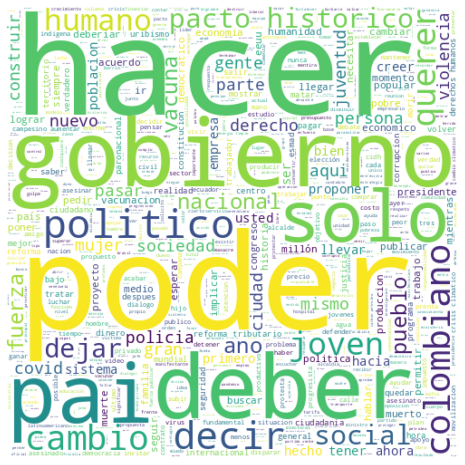

In [21]:
d3 = df_filtrado = train_lem[train_lem['name'] == 1]
df2 = d3.dropna(subset=['text'], axis = 0)['text'].copy()

text = " ".join(s for s in df2)
# checking how many words we have
print("Words: {}".format(len(text)))

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=500, height=500, max_words=800,
                      max_font_size=150,
                      min_font_size=1).generate(text)

fig, ax = plt.subplots(figsize=(10,10), dpi=60)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_axis_off()
plt.show()
wordcloud.to_file("wordcloud_Petro.png")

## Uribe

Words: 304318


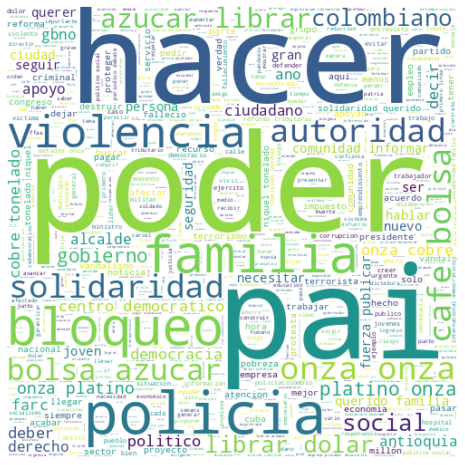

In [22]:
d3 = df_filtrado = train_lem[train_lem['name'] == 2]
df2 = d3.dropna(subset=['text'], axis = 0)['text'].copy()

text = " ".join(s for s in df2)
# checking how many words we have
print("Words: {}".format(len(text)))

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=500, height=500, max_words=800,
                      max_font_size=150,
                      min_font_size=1).generate(text)

fig, ax = plt.subplots(figsize=(10,10), dpi=60)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_axis_off()
plt.show()
wordcloud.to_file("wordcloud_Uribe.png")

## López

Words: 542044


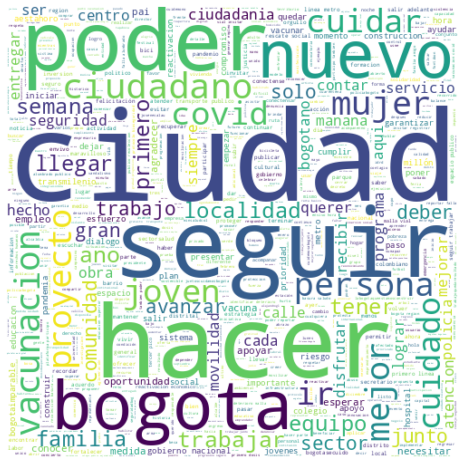

In [23]:
d3 = df_filtrado = train_lem[train_lem['name'] == 3]
df2 = d3.dropna(subset=['text'], axis = 0)['text'].copy()

text = " ".join(s for s in df2)
# checking how many words we have
print("Words: {}".format(len(text)))

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=500, height=500, max_words=800,
                      max_font_size=150,
                      min_font_size=1).generate(text)

fig, ax = plt.subplots(figsize=(10,10), dpi=60)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_axis_off()
plt.show()
wordcloud.to_file("wordcloud_Lopez.png")

# Frecuencia de palabras

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('punkt') # Descarga los datos necesarios para la tokenización
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Una sola palabra

### General

In [25]:
words = []
for text in train_lem['text']:
    words += word_tokenize(text.lower())

In [26]:
stop_words = set(stopwords.words('spanish')) # Selecciona el idioma de las stopwords
words = [word for word in words if word.isalpha() and word not in stop_words]
word_freq = Counter(words)

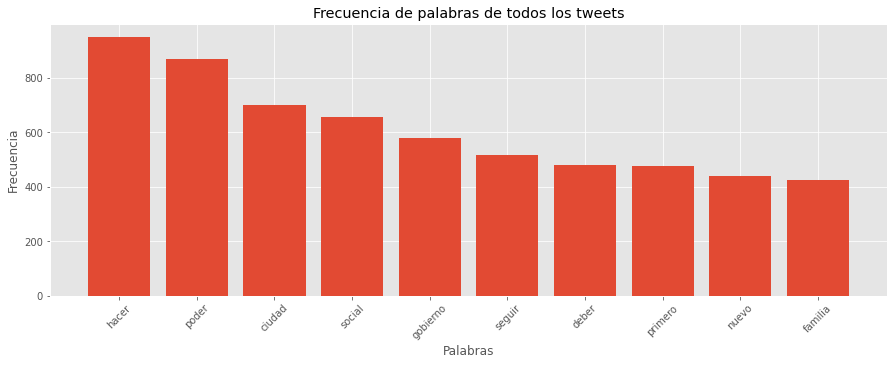

In [27]:
df_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])
df_freq = df_freq.sort_values(by='frequency', ascending=False)
plt.figure(figsize=(15,5))
plt.bar(df_freq.index[:10], df_freq['frequency'][:10])
plt.xticks(rotation=45)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de palabras de todos los tweets')
plt.savefig("Frecuencia_General.png", dpi=300, bbox_inches='tight')
plt.show()

### Petro

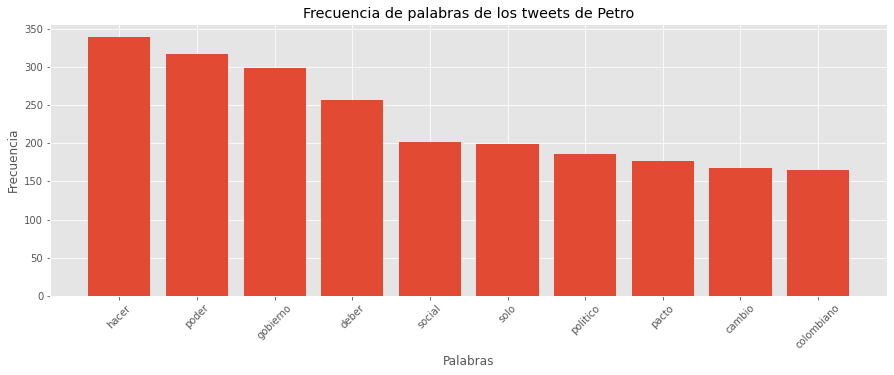

In [28]:
df2 = df_filtrado = train_lem[train_lem['name'] == 1]

words = []
for text in df2['text']:
    words += word_tokenize(text.lower())

words = [word for word in words if word.isalpha() and word not in stop_words]
word_freq = Counter(words)

df_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])
df_freq = df_freq.sort_values(by='frequency', ascending=False)
plt.figure(figsize=(15,5))
plt.bar(df_freq.index[:10], df_freq['frequency'][:10])
plt.xticks(rotation=45)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de palabras de los tweets de Petro')
plt.savefig("Frecuencia_Petro.png", dpi=300, bbox_inches='tight')
plt.show()

### Uribe

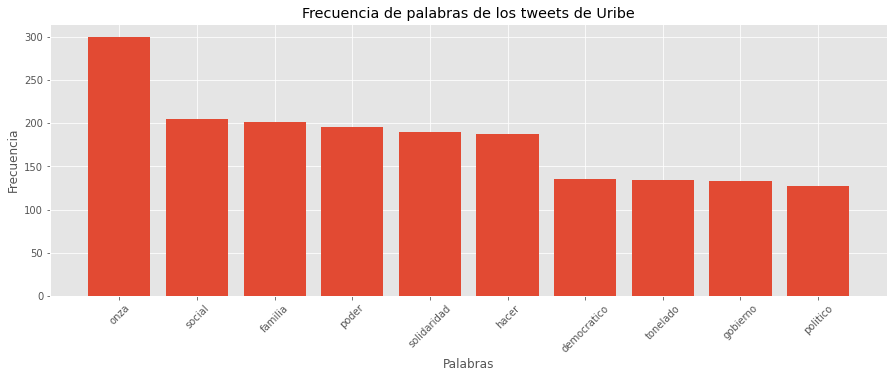

In [29]:
df2 = df_filtrado = train_lem[train_lem['name'] == 2]

words = []
for text in df2['text']:
    words += word_tokenize(text.lower())

words = [word for word in words if word.isalpha() and word not in stop_words]
word_freq = Counter(words)

df_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])
df_freq = df_freq.sort_values(by='frequency', ascending=False)
plt.figure(figsize=(15,5))
plt.bar(df_freq.index[:10], df_freq['frequency'][:10])
plt.xticks(rotation=45)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de palabras de los tweets de Uribe')
plt.savefig("Frecuencia_Uribe.png", dpi=300, bbox_inches='tight')
plt.show()

### López

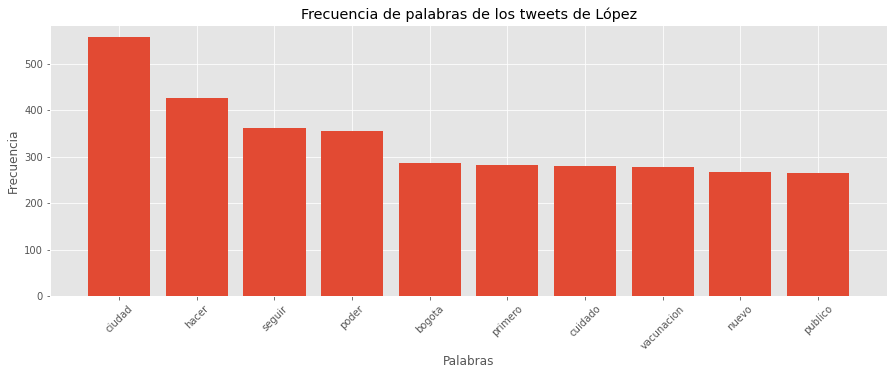

In [30]:
df2 = df_filtrado = train_lem[train_lem['name'] == 3]

words = []
for text in df2['text']:
    words += word_tokenize(text.lower())

words = [word for word in words if word.isalpha() and word not in stop_words]
word_freq = Counter(words)

df_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])
df_freq = df_freq.sort_values(by='frequency', ascending=False)
plt.figure(figsize=(15,5))
plt.bar(df_freq.index[:10], df_freq['frequency'][:10])
plt.xticks(rotation=45)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de palabras de los tweets de López')
plt.savefig("Frecuencia_Lopez.png", dpi=300, bbox_inches='tight')
plt.show()

# Bi-grama

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
from collections import Counter
import itertools

## General

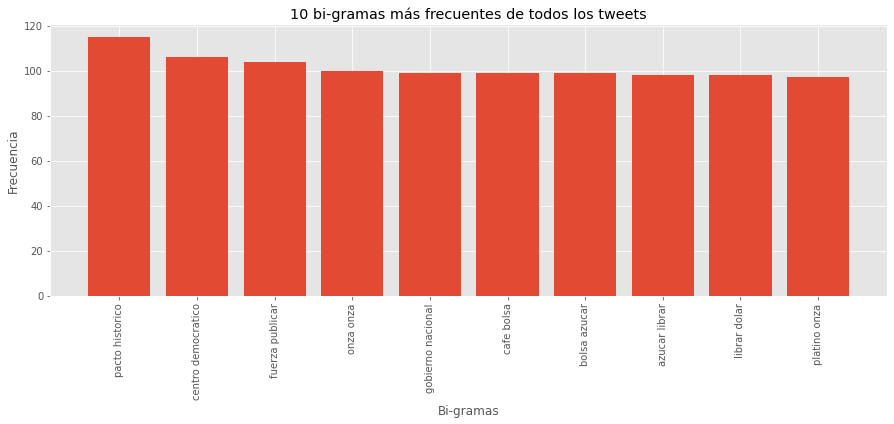

In [32]:
# Tokenización y filtrado de palabras irrelevantes
tokenized = list(itertools.chain.from_iterable([nltk.word_tokenize(text.lower()) for text in train_lem['text']]))

# Crear una lista de tuplas de bi-gramas
bigrams = list(nltk.bigrams(tokenized))

# Contar la frecuencia de los bi-gramas
bigram_counts = Counter(bigrams)

# Obtener los 10 bi-gramas más frecuentes
top_bigrams = bigram_counts.most_common(10)

# Convertir las tuplas de bi-gramas a una lista unidimensional de cadenas
labels = [str(label[0][0]) + ' ' + str(label[0][1]) for label in top_bigrams]

# Convertir la tupla de frecuencias en una lista unidimensional
values = [count for _, count in top_bigrams]

plt.figure(figsize=(15,5))

# Crear un gráfico de barras con los bi-gramas y su frecuencia
plt.bar(labels, values)

# Añadir títulos y etiquetas de ejes
plt.title("10 bi-gramas más frecuentes de todos los tweets")
plt.xlabel("Bi-gramas")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)

plt.savefig("Bi-grama_General.png", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

## Petro

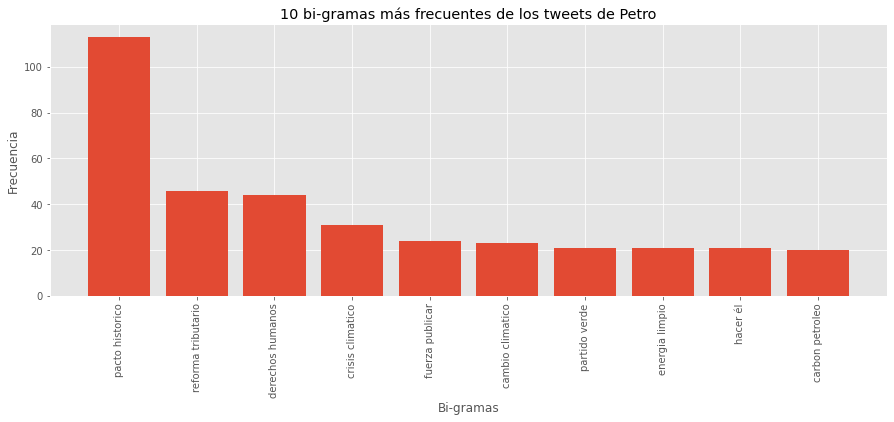

In [33]:
df2 = df_filtrado = train_lem[train_lem['name'] == 1]

# Tokenización y filtrado de palabras irrelevantes
tokenized = list(itertools.chain.from_iterable([nltk.word_tokenize(text.lower()) for text in df2['text']]))

# Crear una lista de tuplas de bi-gramas
bigrams = list(nltk.bigrams(tokenized))

# Contar la frecuencia de los bi-gramas
bigram_counts = Counter(bigrams)

# Obtener los 10 bi-gramas más frecuentes
top_bigrams = bigram_counts.most_common(10)

# Convertir las tuplas de bi-gramas a una lista unidimensional de cadenas
labels = [str(label[0][0]) + ' ' + str(label[0][1]) for label in top_bigrams]

# Convertir la tupla de frecuencias en una lista unidimensional
values = [count for _, count in top_bigrams]

plt.figure(figsize=(15,5))

# Crear un gráfico de barras con los bi-gramas y su frecuencia
plt.bar(labels, values)

# Añadir títulos y etiquetas de ejes
plt.title("10 bi-gramas más frecuentes de los tweets de Petro")
plt.xlabel("Bi-gramas")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)

plt.savefig("Bi-grama_Petro.png", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

## Uribe

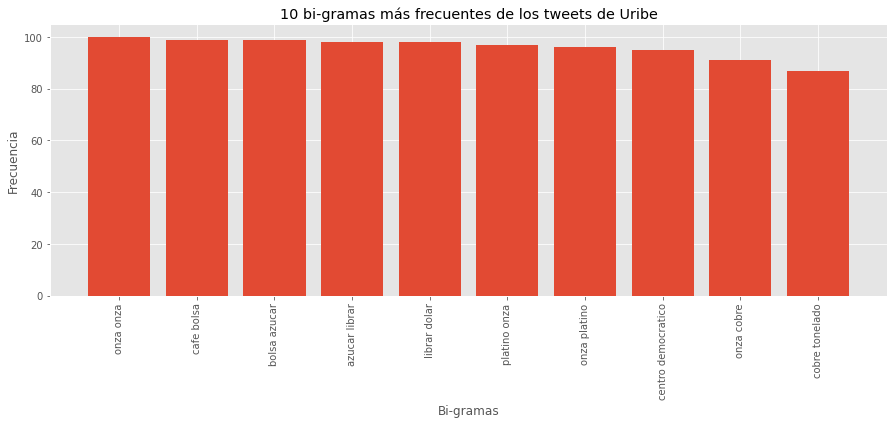

In [34]:
df2 = df_filtrado = train_lem[train_lem['name'] == 2]

# Tokenización y filtrado de palabras irrelevantes
tokenized = list(itertools.chain.from_iterable([nltk.word_tokenize(text.lower()) for text in df2['text']]))

# Crear una lista de tuplas de bi-gramas
bigrams = list(nltk.bigrams(tokenized))

# Contar la frecuencia de los bi-gramas
bigram_counts = Counter(bigrams)

#bigram_counts.pop(('bolsa', 'azucar'), None) # Eliminar bi-gramas que no tienen sentido en el análisis de contexto

# Obtener los 10 bi-gramas más frecuentes
top_bigrams = bigram_counts.most_common(10)


# Convertir las tuplas de bi-gramas a una lista unidimensional de cadenas
labels = [str(label[0][0]) + ' ' + str(label[0][1]) for label in top_bigrams]

# Convertir la tupla de frecuencias en una lista unidimensional
values = [count for _, count in top_bigrams]

plt.figure(figsize=(15,5))

# Crear un gráfico de barras con los bi-gramas y su frecuencia
plt.bar(labels, values)

# Añadir títulos y etiquetas de ejes
plt.title("10 bi-gramas más frecuentes de los tweets de Uribe")
plt.xlabel("Bi-gramas")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)

plt.savefig("Bi-grama_Uribe.png", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

## López

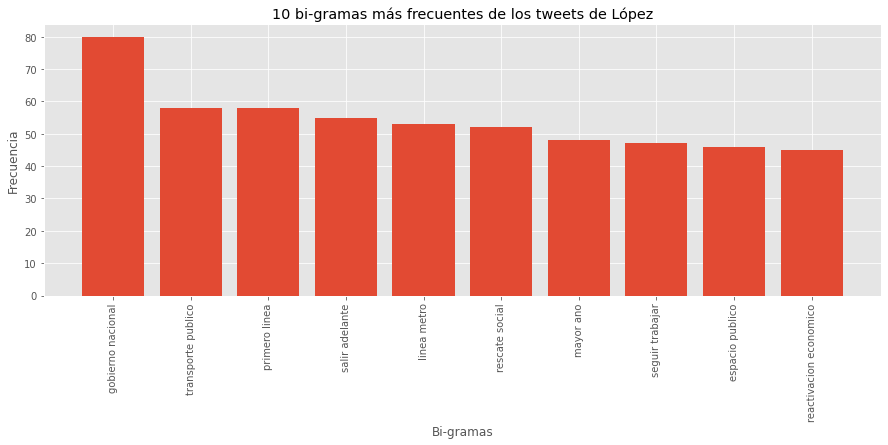

In [35]:
df2 = df_filtrado = train_lem[train_lem['name'] == 3]

# Tokenización y filtrado de palabras irrelevantes
tokenized = list(itertools.chain.from_iterable([nltk.word_tokenize(text.lower()) for text in df2['text']]))

# Crear una lista de tuplas de bi-gramas
bigrams = list(nltk.bigrams(tokenized))

# Contar la frecuencia de los bi-gramas
bigram_counts = Counter(bigrams)

# Obtener los 10 bi-gramas más frecuentes
top_bigrams = bigram_counts.most_common(10)

# Convertir las tuplas de bi-gramas a una lista unidimensional de cadenas
labels = [str(label[0][0]) + ' ' + str(label[0][1]) for label in top_bigrams]

# Convertir la tupla de frecuencias en una lista unidimensional
values = [count for _, count in top_bigrams]

plt.figure(figsize=(15,5))

# Crear un gráfico de barras con los bi-gramas y su frecuencia
plt.bar(labels, values)

# Añadir títulos y etiquetas de ejes
plt.title("10 bi-gramas más frecuentes de los tweets de López")
plt.xlabel("Bi-gramas")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)

plt.savefig("Bi-grama_Lopez.png", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()